# Q1.1.1

In [53]:
# Import the necessary libraries
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FormatStrFormatter

import scipy.stats as stats
from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.special import expit, logit

In [54]:
# set hyperparameters for common voxels and slices we will be using
im_slice = 71
vox_i = 91
vox_j = 64
dim_i = 145
dim_j = 174

In [55]:
# Load in the diffusion MRI data set and calculate settings for each component image
dwis = loadmat('data.mat')['dwis']
dwis = np.double(dwis)
dwis = dwis.transpose((3, 0, 1, 2))
[Dc, Dx, Dy, Dz] = dwis.shape

qhat = np.loadtxt("bvecs", delimiter = " ").T
bvals = 1000 * np.sum(qhat * qhat, axis=1)

In [56]:
# Solve for x in log(A) = Gx - where x has all unknowns
x = np.zeros((dim_i, dim_j, 7))
quadratic_matrix = -bvals * np.array([qhat[:,0]**2, 2*qhat[:,0]*qhat[:,1], 2*qhat[:,0]*qhat[:,2], qhat[:,1]**2, 2*qhat[:,1]*qhat[:,2], qhat[:,2]**2])
G = np.concatenate([np.ones((108,1)), quadratic_matrix.T], axis=1)

# for each voxel calculate the solution
for i in range(dim_i):
    for j in range(dim_j):
        A = dwis[:,i,j,im_slice]
        if np.min(A) > 0:
            W = np.diag(A**2)
            invmap = np.linalg.pinv(G.T @ W @ G) @ G.T @ W
            x[i,j,:] = invmap @ np.log(A)

# calculate the DT for each voxel
D = np.zeros((dim_i,dim_j,3,3))
for i in range(dim_i):
    for j in range(dim_j):
        Dxx = x[i,j,1]
        Dxy = x[i,j,2]
        Dxz = x[i,j,3]
        Dyy = x[i,j,4]
        Dyz = x[i,j,5]
        Dzz = x[i,j,6]
        D[i,j] = np.array(
            [[Dxx, Dxy, Dxz],
             [Dxy, Dyy, Dyz],
             [Dxz, Dyz, Dzz]]
        )



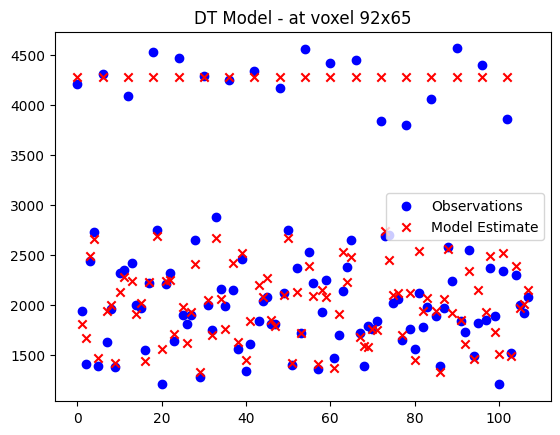

In [57]:
# Plot the model estimate against the measure signal at voxel 92x65

A_est = np.exp(G @ np.squeeze(x[vox_i,vox_j,:]).reshape((-1,1)))
A_exact = np.squeeze(dwis[:,vox_i,vox_j,im_slice])
# Create grid of subplots
plt.scatter(np.arange(108), A_exact, marker='o', color='b', label='Observations')
plt.scatter(np.arange(108), A_est, marker='x', color='r', label='Model Estimate')
plt.legend()
plt.title(f'DT Model - at voxel {vox_i+1}x{vox_j+1}')
plt.show()

In [58]:
# Calculate mean diffusivity across the image
mean_D = np.zeros((dim_i,dim_j))

for i in range(dim_i):
    for j in range(dim_j):
        mean_D[i,j] = np.trace(D[i,j]) / 3

# Calculate FA
FA = np.zeros((dim_i,dim_j))
eig_val_D = np.zeros(((dim_i,dim_j,3)))
eig_vec_D = np.zeros((dim_i,dim_j,3,3))

for i in range(dim_i):
    for j in range(dim_j):
        eig_val, eig_vec = np.linalg.eig(np.squeeze(D[i,j]))
        eig_vec_D[i,j,:,:] = eig_vec
        eig_val_D[i,j,:] = eig_val
        if eig_val.sum() > 0:
            FA[i,j] = np.sqrt(1.5 * np.sum((eig_val - eig_val.mean())**2) / (eig_val**2).sum())

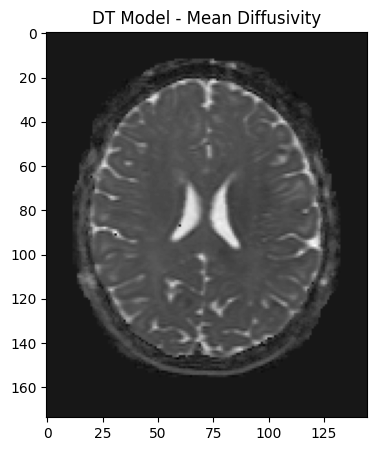

In [59]:
# plot Mean Diffusivity
fig, axs = plt.subplots(1, figsize=(5, 5))

axs.imshow(np.flipud(mean_D.T), cmap='gray')
axs.set_title('DT Model - Mean Diffusivity')

# Show the plot
plt.show()


<function numpy.transpose(a, axes=None)>

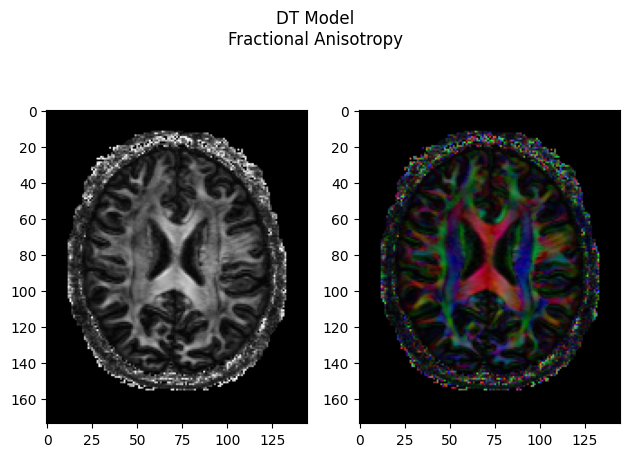

In [60]:
# Plot the FA weighted with eigenvalues on RBG spectrum
FA_RGB = np.zeros((dim_i,dim_j,3))

for i in range(dim_i):
    for j in range(dim_j):
        principal_eig_idx = np.argmax(np.abs(eig_val_D[i,j]))
        if eig_val_D[i,j,principal_eig_idx] > 0:
            eig_vec = eig_vec_D[i,j,:,principal_eig_idx]
            FA_RGB[i,j,:] = FA[i,j] * np.abs(np.array([eig_vec[0], eig_vec[1], eig_vec[2]]))

# normalise RGB values
FA_RGB = FA_RGB / np.max(FA_RGB)

# print to screen FA_RGB
fig, axs = plt.subplots(1, 2)
fig.suptitle('DT Model\nFractional Anisotropy')

axs[0].imshow(np.flipud(FA.T), cmap='gray')

axs[1].imshow(np.flipud(np.transpose(FA_RGB, (1,0,2))))

plt.tight_layout()
np.transpose


# Q1.1.2
### Ball and Stick Model

In [61]:
def ball_stick(x):
    
    # Extract the parameters
    # diff: diffusion
    # f: fraction of signal contributed by diffusion tensor along fiber direction theta, phi
    S0, diff, f, theta, phi = x
    
    # Fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta),
    ])
    
    # creates a 2D array of fibdir stacked ontop of each other len(bvals) times
    # so now has the dimensions [len(bvals)x3]
    tile = np.tile(fibdir, (len(bvals), 1))
    fibdotgrad = np.sum(qhat * tile, axis=1)
    
    S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1-f) * np.exp(-bvals * diff))
    return S


def BallStickSSD(x, voxel):
    S = ball_stick(x)
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)

In [62]:
# Use minimize for non-linear estimation of the ball-and-stick parameters
# The first starting point finds a spurious local min; the second
# a more reasonable min.
avox = dwis[:,vox_i,vox_j,im_slice]
#startx = np.array([3500, -5e-6, 120, 0, 0])
#startx = np.array([4200, 4e-4, 0.25, 0, 0])
# start given by moodle note:
startx = np.array([3300, 1.0e-03, 4.5e-01, 1.0, 1.0])
results = minimize(
    fun=BallStickSSD,
    x0=startx,
    args=(avox,),
)

results

C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1453691858.py:20: RuntimeWarning: overflow encountered in exp
  S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1-f) * np.exp(-bvals * diff))
c:\Users\fl_cl\miniconda3\envs\MV00-py3.9\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1453691858.py:20: RuntimeWarning: overflow encountered in exp
  S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1-f) * np.exp(-bvals * diff))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1453691858.py:27: RuntimeWarning: overflow encountered in square
  return np.sum((voxel - S) ** 2)


      fun: 54806552.90143531
 hess_inv: array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])
      jac: array([-4.47215000e+04,  4.98960658e+10,  1.76876395e+07, -1.44313685e+07,
        1.24521480e+07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 30
      nit: 0
     njev: 3
   status: 2
  success: False
        x: array([3.3e+03, 1.0e-03, 4.5e-01, 1.0e+00, 1.0e+00])

error mean: -318.7
error std: 640.1
expected SS: 4320000.0, calculated SS: 54806552.9, diff: -50486552.9


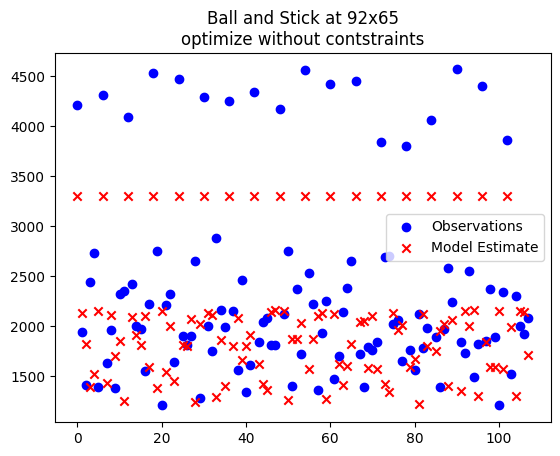

In [63]:
# Use the fitted parameters to get estimated values
A_est = ball_stick(results['x'])
A_exact = np.squeeze(dwis[:,vox_i,vox_j,im_slice])

# Find the mean and std of the errors
error_dist = stats.describe(A_est - A_exact)
error_mean = error_dist[2]
error_var = error_dist[3]
print(f"error mean: {error_mean:.1f}")
print(f"error std: {np.sqrt(error_var):.1f}")

# Use the given noise std to calculate the expected SSD
ss_expected = 108 * 200**2
ss_exact = results['fun']
print(f"expected SS: {ss_expected:.1f}, calculated SS: {ss_exact:.1f}, diff: {(ss_expected - ss_exact):.1f}")

# Create grid of subplots to compare
plt.scatter(np.arange(108), A_exact, marker='o', color='b', label='Observations')
plt.scatter(np.arange(108), A_est, marker='x', color='r', label='Model Estimate')
plt.legend()
plt.title(f'Ball and Stick at {vox_i+1}x{vox_j+1}\noptimize without contstraints')
plt.show()

# Q1.1.3

In [64]:
# We are now constraining the parameters (S0, diff >0, f in (0,1), theta, phi in (0,2pi))
# We do this by transforming x to be squared, or expit() and scaled to ensure they are in the 
# correct domain. Because the transformation happens after the optimizer guesses x_t+1 we
# have to transform the optimized solution to get the correct fitted parameters

# Given S0**0.5, diff**0.5, logit(f), logit(theta/pi) and logit(phi/2*pi) - we transform back to domain we want it
def transform(x):
    return [x[0]**2, x[1]**2, expit(x[2]), expit(x[3])*np.pi, expit(x[4])*2*np.pi]

# Given S0, diff, f, theta, and phi, we inverse transform it to the unconstrained domain
def transform_inv(x):
    return [x[0]**0.5, x[1]**0.5, logit(x[2]), logit(x[3]/(np.pi)), logit(x[4]/(2*np.pi))]

def BallStickSSD_constrained(x, voxel):
    # given x that is unconstrained, we transform it to our wanted domain
    S = ball_stick(transform(x))
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)


In [65]:
# Use the transform to find the parameters constrained
# note: stratx is in our constrained domain, so we have to inverse transform it to be in
# the unconstrained domain
results = minimize(
    fun=BallStickSSD_constrained,
    x0=transform_inv(startx),
    args=(avox,),
)

results

# With constraints the fitting works and we get sensible results (S0, diff >0, etc.)
# and plotting against observed values we get much better results

      fun: 5871996.800798102
 hess_inv: array([[ 2.20165758e-05, -4.17141458e-08,  5.44591774e-06,
         4.70446133e-06,  5.50197618e-06],
       [-4.17141458e-08,  8.06144786e-11, -1.04697159e-08,
        -8.87274028e-09, -1.03730058e-08],
       [ 5.44591774e-06, -1.04697159e-08,  1.38064626e-06,
         1.15553132e-06,  1.34915466e-06],
       [ 4.70446133e-06, -8.87274028e-09,  1.15553132e-06,
         1.01518555e-06,  1.19411094e-06],
       [ 5.50197618e-06, -1.03730058e-08,  1.34915466e-06,
         1.19411094e-06,  1.47570995e-06]])
      jac: array([ 0.1875,  5.3125, -0.125 , -0.3125,  0.0625])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 448
      nit: 32
     njev: 73
   status: 2
  success: False
        x: array([ 6.52527790e+01, -3.37830607e-02, -5.87056279e-01,  7.89459938e-01,
       -2.28680659e+00])

found fitted x = [4257.925168015598, 0.0011412951873726808, 0.35731056530927585, 2.1605215137495395, 0.5794450483984238]
error mean: 0.11698199288636496
error std: 234.26152257921527
estimated SS: 4320000, calculated SS: 5871996.800798102, diff: -1551996.8007981023


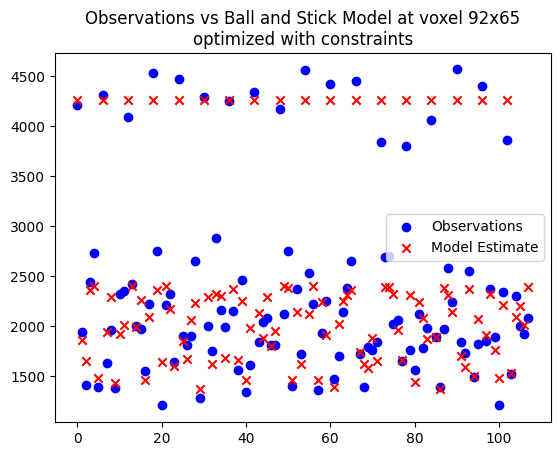

In [74]:
# Use the fitted parameters to get estimated values
print(f"found fitted x = {transform(results['x'])}")
#A_est = ball_stick(transform(results['x']))
#A_exact = np.squeeze(dwis[:,91,64,71])
A_est = ball_stick(transform(results['x']))
A_exact = np.squeeze(dwis[:,vox_i,vox_j,im_slice])

# Find the mean and std of the errors
error_dist = stats.describe(A_est - A_exact)
error_mean = error_dist[2]
error_var = error_dist[3]
print(f"error mean: {error_mean}")
print(f"error std: {np.sqrt(error_var)}")

# Use the standard deviation to calculate the estimated Sum of Squares diff
ss_expected = 108 * 200*200
ss_exact = results['fun']
print(f"estimated SS: {ss_expected}, calculated SS: {ss_exact}, diff: {ss_expected - ss_exact}")

# Create grid of subplots to compare
plt.scatter(np.arange(108), A_exact, marker='o', color='b', label='Observations')
plt.scatter(np.arange(108), A_est, marker='x', color='r', label='Model Estimate')
plt.legend()
plt.title(f'Observations vs Ball and Stick Model at voxel {vox_i+1}x{vox_j+1}\noptimized with constraints')
plt.show()

Sum of sqares has significantly reduced because now the model is fitting the observed data much better

# Q1.1.4

In [75]:
# for the same voxel run multiple times to try and find the best minimum
def BallStickSSD_constrained_findSSDmin(max_iter, startx, avox):
    # given parameters of a single avox, run max_iter times and find converged SSD each time
    # return all found solutions and SSD values
    
    noise_std = startx / 5
    num_parameters = startx.size
    X_single_voxel = np.zeros((max_iter, num_parameters))
    X_SSD = np.zeros(max_iter)

    for i in range(max_iter):
        # find some noise, add to the start, and transform and inverse it to make sure the 
        # peturbed start is a realistic start
        noise = np.random.normal(loc=np.zeros(num_parameters), scale=noise_std)
        x_i = startx + noise
        x_i = transform_inv(transform(x_i))
        results = minimize(
            fun=BallStickSSD_constrained,
            x0=transform_inv(x_i),
            args=(avox,),
        )
        X_single_voxel[i,:] = results['x']
        SSD_result = results['fun']
        if np.isnan(SSD_result):
            SSD_result = np.inf
        X_SSD[i] = SSD_result
    
    return X_single_voxel, X_SSD


def find_prob_finding_SSD_globalmin(startx, avox, max_iter=100, eps=1e-1):
    # given a voxex, and a starting position. Optimize to solve for x with 95% confidence the global minima has been found
    
    X_single_voxel, X_SSD = BallStickSSD_constrained_findSSDmin(max_iter, startx=startx, avox=avox)
    
    min_SSD = np.min(X_SSD)
    min_SSD_count = np.isclose(X_SSD, min_SSD, eps).sum()
    p = min_SSD_count / X_SSD.shape[0]
    print(f"min_SSD: {min_SSD}, found min {min_SSD_count} times, prob_global_min = {p}")
    return p

# given prob of finding global min, return how many times we have to run optimisation
# to have 95% chance of finding it
def find_N_for_95percent_global_min(p):
    return int(np.ceil(np.log(0.05) / np.log(1-p)))

In [76]:
# Check a number of different voxels for the number of times we have to run optimisation
# to have a 95% prob of finding the global min
voxel_idxs = np.array([[vox_i,vox_j], [60,60], [55,55], [80,60], [85,55], [85, 72], [70, 70]])
N_array = np.zeros(shape=voxel_idxs.shape[0])

for i, voxel_idx in enumerate(voxel_idxs):
    p = find_prob_finding_SSD_globalmin(startx, dwis[:, voxel_idx[0], voxel_idx[1], im_slice], max_iter=100)
    N_array[i] = find_N_for_95percent_global_min(p)

print(f"Found Ns: {N_array}")
N_global_min = int(N_array.max())
print(f"Will use the max N found in our small sample: max_N = {N_global_min}")

min_SSD: 5871996.800722258, found min 83 times, prob_global_min = 0.83
min_SSD: 3973422.1850034627, found min 99 times, prob_global_min = 0.99
min_SSD: 6565608.199859387, found min 100 times, prob_global_min = 1.0


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1425925943.py:45: RuntimeWarning: divide by zero encountered in log
  return int(np.ceil(np.log(0.05) / np.log(1-p)))


min_SSD: 3494706.812751126, found min 88 times, prob_global_min = 0.88
min_SSD: 3234355.1259054383, found min 32 times, prob_global_min = 0.32
min_SSD: 8882585.58418229, found min 32 times, prob_global_min = 0.32
min_SSD: 4253463.440310008, found min 98 times, prob_global_min = 0.98
Found Ns: [2. 1. 0. 2. 8. 8. 1.]
Will use the max N found in our small sample: max_N = 8


# Q1.1.5

In [77]:
# use the found max N found across checked voxels to find the global min at each voxel in image slice

# Note: this function takes a while so the solution has been run once and saved down
# change is_skip to FALSE to re-calculate from scratch
is_skip = True
file_path = "X_optimize_each_voxel_with_same_N.npy"

if not is_skip:
    X = np.zeros((dim_i, dim_j, startx.size))
    X = np.load(file_path)

    for i in range(dim_i):
        for j in range(dim_j):
            A = dwis[:,i,j,im_slice]
            if np.min(A) > 0:
                x_single_voxel, x_SSD = BallStickSSD_constrained_findSSDmin(N_global_min, startx, dwis[:,i,j,im_slice])
                min_idx = np.argmin(x_SSD)
                X[i,j,:] = transform(x_single_voxel[min_idx,:])
        # save each row to a file
        np.save(file_path, X)
        print(f"row {i} complete")
else:
    X = np.load(file_path)



In [90]:
# Calculate RESNORM across the image slice

RESNORM = np.zeros(shape=(dim_i, dim_j))

for i in range(dim_i):
    for j in range(dim_j):
        RESNORM[i,j] = BallStickSSD(X[i,j,:], voxel=dwis[:,i,j, im_slice])

In [98]:
(RESNORM > 4e7).sum()

11

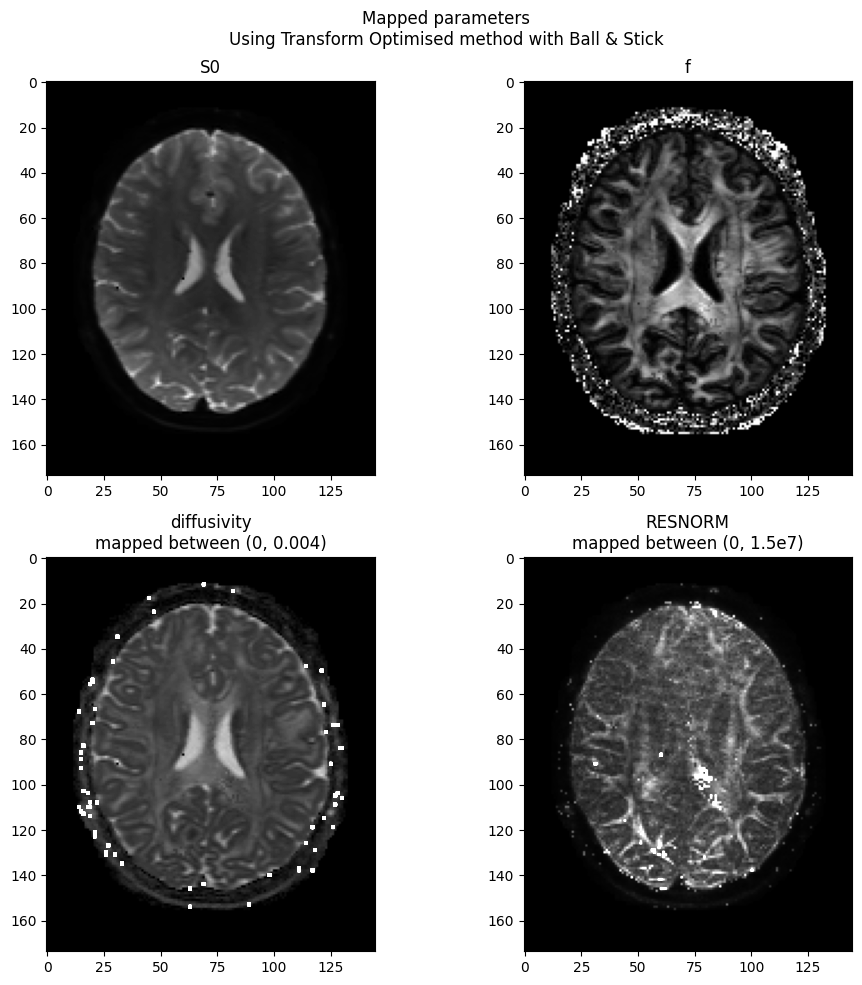

In [113]:
# plot the S0, d, f, and the RESNORM, and fibre direction of n

S0 = X[:,:,0]
d_raw = X[:,:,1]
d_processed = np.where(d_raw > 3, 0, d_raw)
f = X[:,:,2]
theta = X[:,:,3]
phi = X[:,:,4]

n_zplane_x = np.sin(theta) * np.cos(phi) * f
n_zplane_y = - np.sin(theta) * np.sin(phi) * f

n_yplane_x = np.sin(theta) * np.sin(phi) * f
n_yplane_y = np.cos(theta) * f


# plot FA
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2,2, figsize=(10, 10))
fig.suptitle('Mapped parameters\nUsing Transform Optimised method with Ball & Stick')

axs[0,0].imshow(np.flipud(S0.T), cmap='gray')
axs[0,0].set_title('S0')

axs[0,1].imshow(np.flipud(f.T), cmap='gray')
axs[0,1].set_title('f')

axs[1,0].imshow(np.flipud(d_raw.T), cmap='gray', vmax=0.004)
axs[1,0].set_title('diffusivity\nmapped between (0, 0.004)')

axs[1,1].imshow(np.flipud(RESNORM.T), cmap='gray', vmax=1.5e7)
axs[1,1].set_title('RESNORM\nmapped between (0, 1.5e7)')

# Show the plot
plt.tight_layout()
plt.show()

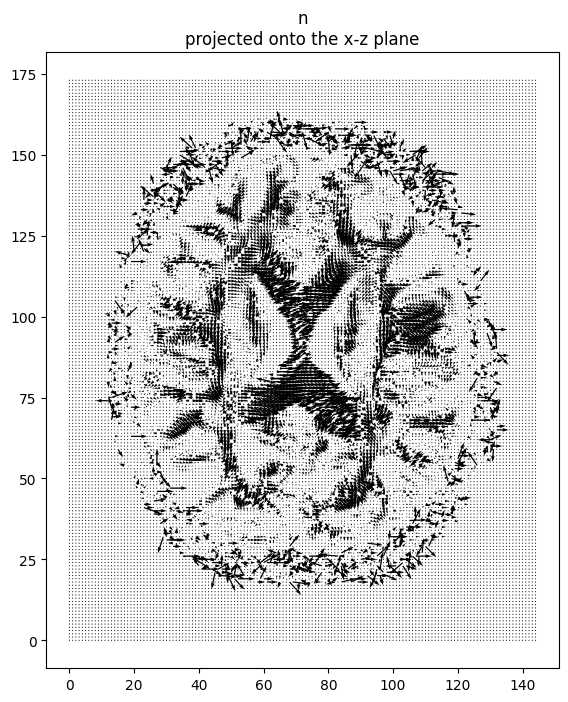

In [114]:

fig, axs = plt.subplots(1, figsize=(8, 8))

axs.quiver(n_zplane_x.T, n_zplane_y.T)
axs.set_title('n\nprojected onto the x-z plane')
axs.set_aspect('equal')

plt.show()

There are many outliers in the found parameters so there are some found parameters that don't have found solutions. This can be seen in the diffusivity model where the found solutions are much larger than they should be which skews the mapping making the image black with a few highlighted outliers. If we only plot diffusivity for the majority (d < 0.005) then we get more of a picture we would expect (outliers are very bright in that image)

# Q1.2.1

In [22]:
# Classical Bootstrapping method
# Sample with replacement T times to get A_t sampled data set. Each data set solve for parameters
# Plot the found parameters on a histogram and keep the middle 95%. Calculate sigma for the estimate
def calssical_bootstrap_find_parameters(vox_i, vox_j, im_slice, T=300):
    N_data = dwis.shape[0]
    # create indexes for T different iteration, each iteration have N samples indexes
    sampled_idxs = np.random.randint(N_data, size=(T,N_data))
    bootstrap_parameters = np.zeros(shape=(T, 5))

    for t in range(T):
        A_t = dwis[sampled_idxs[t], vox_i, vox_j, im_slice]
        if np.min(A_t > 0):
            x_single_voxel, x_SSD = BallStickSSD_constrained_findSSDmin(N_global_min, startx, A_t)
            min_idx = np.argmin(x_SSD)
            bootstrap_parameters[t,:] = transform(x_single_voxel[min_idx,:])
    
    return bootstrap_parameters


In [23]:
# method to plot the histogram of bootstrap parameters given data and axes
def plot_histogram_sigma_95percent(axs, data, title, shade_colour='grey', shade_alpha=0.4, sigma_line_colour='red', mean_colour='black', is_legend=False):
    T = data.size
    data_std = np.std(data)
    data_sorted_idx = np.argsort(data)
    data_95_idx = [data_sorted_idx[int(T * 0.025)], data_sorted_idx[int(T * 0.975)]]
    data_95_range = [data[data_95_idx[0]], data[data_95_idx[1]]]
    data_2sigma_range = [data.mean() - 2*data_std, data.mean() + 2*data_std]

    # plot histograms of data with shaded 95% region, and line showing 2 sigma range
    height_values, _, _ = axs.hist(data)
    axs.axvspan(xmin=data_95_range[0], xmax=data_95_range[1], facecolor=shade_colour, alpha=shade_alpha, label='95% confidence')
    axs.plot(data_2sigma_range, [height_values.max()/2,height_values.max()/2], marker='|', c=sigma_line_colour, label='2 sigma range')
    axs.scatter(data.mean(), height_values.max()/2, marker='x', c=mean_colour, label='parameter mean')
    if is_legend:
        axs.legend()
    axs.set_title(title)
    
    return data_95_range, data_2sigma_range

Bootstrap parameter ranges

Voxel: 92x65
S0: mean = 2512.9439277694146, 95% confidence = [2303.56983535 2848.79701057], 2sigma range = [2241.42232275 2784.46553279]
Diffusivity: mean = 0.00021730923051762778, 95% confidence = [5.66891056e-17 3.96760848e-04], 2sigma range = [2.55488563e-05 4.09069605e-04]
f: mean = 0.9279058231478936, 95% confidence = [0.46330914 1.        ], 2sigma range = [0.58084844 1.27496321]

Voxel: 81x61
S0: mean = 2897.264541003778, 95% confidence = [2636.9163972  3347.06240061], 2sigma range = [2555.74923004 3238.77985196]
Diffusivity: mean = 0.00020376886010422008, 95% confidence = [5.63018166e-17 3.93048651e-04], 2sigma range = [1.89959547e-05 3.88541765e-04]
f: mean = 0.9324209758645752, 95% confidence = [0.44639918 1.        ], 2sigma range = [0.62830513 1.23653682]

Voxel: 61x61
S0: mean = 3274.77662512367, 95% confidence = [2597.16298309 4328.29270764], 2sigma range = [2419.67989529 4129.87335496]
Diffusivity: mean = 0.00048394185012544486, 95% confidence

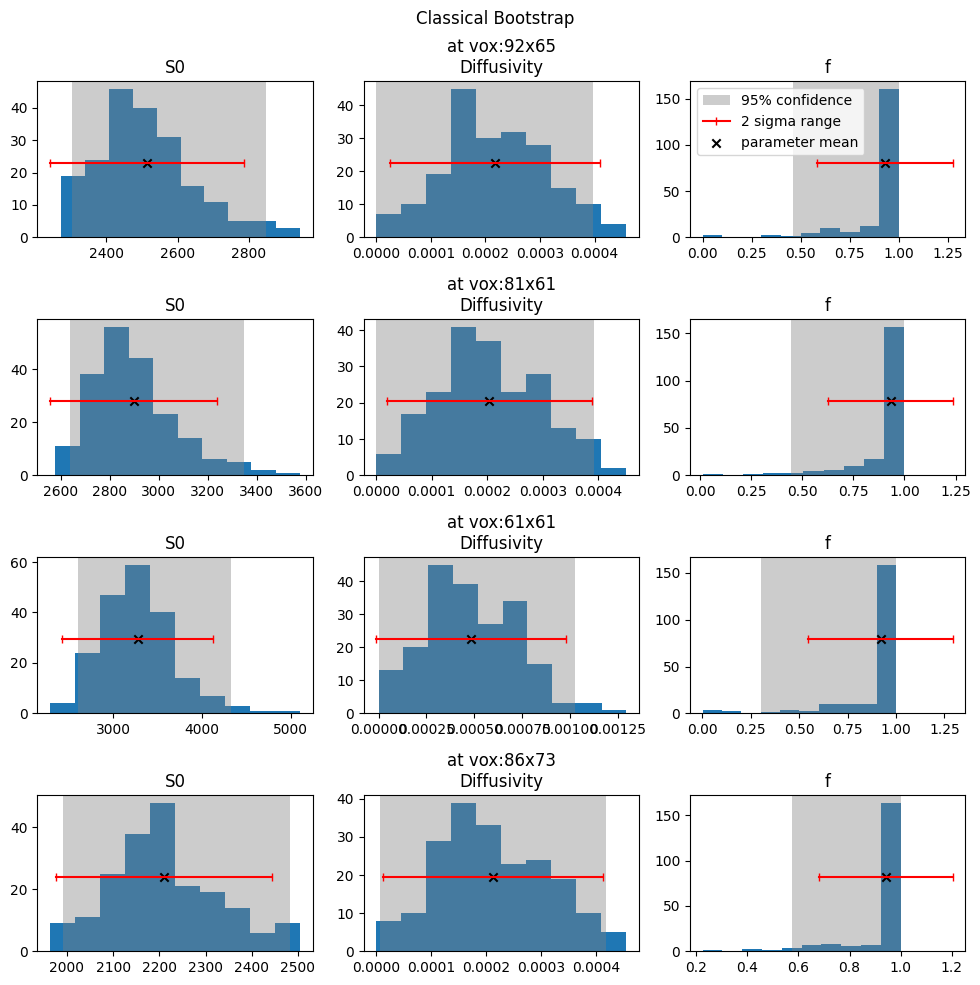

In [118]:
# use classical bootstrapping method to find a range of parameters and plot on a histogram

vox_is = np.array([vox_i, 80, 60, 85])
vox_js = np.array([vox_j, 60, 60, 72])

num_vox = vox_is.size

bootstrap_2sigma_range = np.zeros(shape=(num_vox,2))
bootstrap_95_range = np.zeros(shape=(num_vox,2))

fig, axs = plt.subplots(num_vox,3, figsize=(10, 10))
fig.suptitle(f'Classical Bootstrap')

print('Bootstrap parameter ranges\n')
for vox in range(vox_is.size):
    if vox==0:
        is_legend=True
    else:
        is_legend=False
    bootstrap_parameters = calssical_bootstrap_find_parameters(vox_is[vox], vox_js[vox], im_slice=im_slice, T=200)
    bootstrap_95_range[0,:], bootstrap_2sigma_range[0,:] = plot_histogram_sigma_95percent(axs[vox, 0], bootstrap_parameters[:,0], 'S0')
    bootstrap_95_range[1,:], bootstrap_2sigma_range[1,:] = plot_histogram_sigma_95percent(axs[vox, 1], bootstrap_parameters[:,1], f'at vox:{vox_is[vox]+1}x{vox_js[vox]+1}\nDiffusivity')
    bootstrap_95_range[2,:], bootstrap_2sigma_range[2,:] = plot_histogram_sigma_95percent(axs[vox, 2], bootstrap_parameters[:,2], 'f', is_legend=is_legend)

    # print the ranges for each parameter:
    print(f'Voxel: {vox_is[vox]+1}x{vox_js[vox]+1}')
    print(f"S0: mean = {bootstrap_parameters.mean(axis=0)[0]}, 95% confidence = {bootstrap_95_range[0]}, 2sigma range = {bootstrap_2sigma_range[0]}")
    print(f"Diffusivity: mean = {bootstrap_parameters.mean(axis=0)[1]}, 95% confidence = {bootstrap_95_range[1]}, 2sigma range = {bootstrap_2sigma_range[1]}")
    print(f"f: mean = {bootstrap_parameters.mean(axis=0)[2]}, 95% confidence = {bootstrap_95_range[2]}, 2sigma range = {bootstrap_2sigma_range[2]}\n")

plt.tight_layout()

The first two plots for S0 and d match fairly well between 2 sigma range and the diffusivity which gives evidence that the distribution could be approximated as a normal. But the f clearly cannot. This is mainly driven by f being close to it's upperlimit of 1

# Q1.2.2
MCMC

for t in range(T):
    y is sampled from dist Q
    calculate alpha(x_t-1, y)
    if alpha > U(0,1):
        x_t = y
    else
        x_t = x_t-1
    remove burn in
    take every stride-th element as sample
    return sample_dist

In [25]:
# given a ndarray of points, and a ndarray of standard deviations for each dimension
# return a point sampled from a gaussian located at the point with std
def q_sample_from_dist(x, param_std):
    # add noise, then transform and inverse then inverse to ensure we remain within our domain
    return transform(transform_inv(x + np.random.randn(x.size) * param_std))

# given parameters x and y, calculate the probability of p(A|y) / p(A|x)
# ie. how likely are we to sample y relative to x
# note: this is assuming the q distribution is symmetrical
def alpha_prob_ratio(y, x, data, noise_std):
    x_SSD = BallStickSSD(x, data)
    y_SSD = BallStickSSD(y, data)
    return np.exp((1 / (2 * noise_std**2)) * (x_SSD - y_SSD)) * (np.sin(y[3]) / np.sin(x[3]))

# given burn_in, number of samples to throw away after burn (stride), and other parameters
# return the samples sequence from the distribution p(x|A)
def MCMC(data, x0=startx, burn_in=100, stride=10, sample_length=100, param_std=startx/5, noise_std=200):
    param_num = 5
    raw_sequence_length = burn_in + stride * sample_length
    raw_sequence = np.zeros(shape=(raw_sequence_length, param_num))
    accepted = np.zeros(raw_sequence_length)
    
    # initialise parameters
    raw_sequence[0,:] = x0
    
    for t in range(1, raw_sequence_length):
        x = raw_sequence[t-1,:]
        y = q_sample_from_dist(x, param_std)
        alpha = alpha_prob_ratio(y, x, data, noise_std=noise_std)
        if alpha > np.random.rand():
            raw_sequence[t] = y
            accepted[t] = 1
        else:
            raw_sequence[t] = x
    
    acceptance_after_burn = accepted[burn_in:].sum()/(raw_sequence_length-burn_in)
    print(f"MCMC Complete: Total sequence length {raw_sequence_length}\nraw acceptance rate of {100*accepted.sum()/raw_sequence_length:.0f}%")
    print(f"after burn in acceptance rate of {100*acceptance_after_burn:.0f}%")
    
    after_burn_sequence = raw_sequence[burn_in:]
    final_sequence_idxs = np.arange(sample_length) * stride
    return after_burn_sequence[final_sequence_idxs], acceptance_after_burn
        

In [26]:
burn_in = 2000
stride = 5
sample_length = 2000

# 82% total
#param_std=np.array([1e1, 1e-6, 1e-3, 1e-2, 1e-2])
# 50% individual
#param_std=np.array([5e1, 4e-5, 2e-2, 6e-2, 8e-2])
# 70% individual
param_std=np.array([3e1, 1.5e-5, 1e-2, 2e-2, 3e-2])

data = dwis[:, vox_i, vox_j, im_slice]
MCMC_sequence, acceptance_rate = MCMC(data, startx, burn_in=burn_in, stride=stride, sample_length=sample_length, param_std=param_std, noise_std=200)

MCMC Complete: Total sequence length 12000
raw acceptance rate of 44%
after burn in acceptance rate of 44%


MCMC parameter ranges

Voxel: 92x65
S0: mean = 4256.181573441782, 95% confidence = [0.3224830446670277, 0.39191693745182765], 2sigma range = [0.32050394655481507, 0.3927476439974257]
Diffusivity: mean = 0.0011394204926439757, 95% confidence = [0.3224830446670277, 0.39191693745182765], 2sigma range = [0.32050394655481507, 0.3927476439974257]
f: mean = 0.35662579527612037, 95% confidence = [0.3224830446670277, 0.39191693745182765], 2sigma range = [0.32050394655481507, 0.3927476439974257]



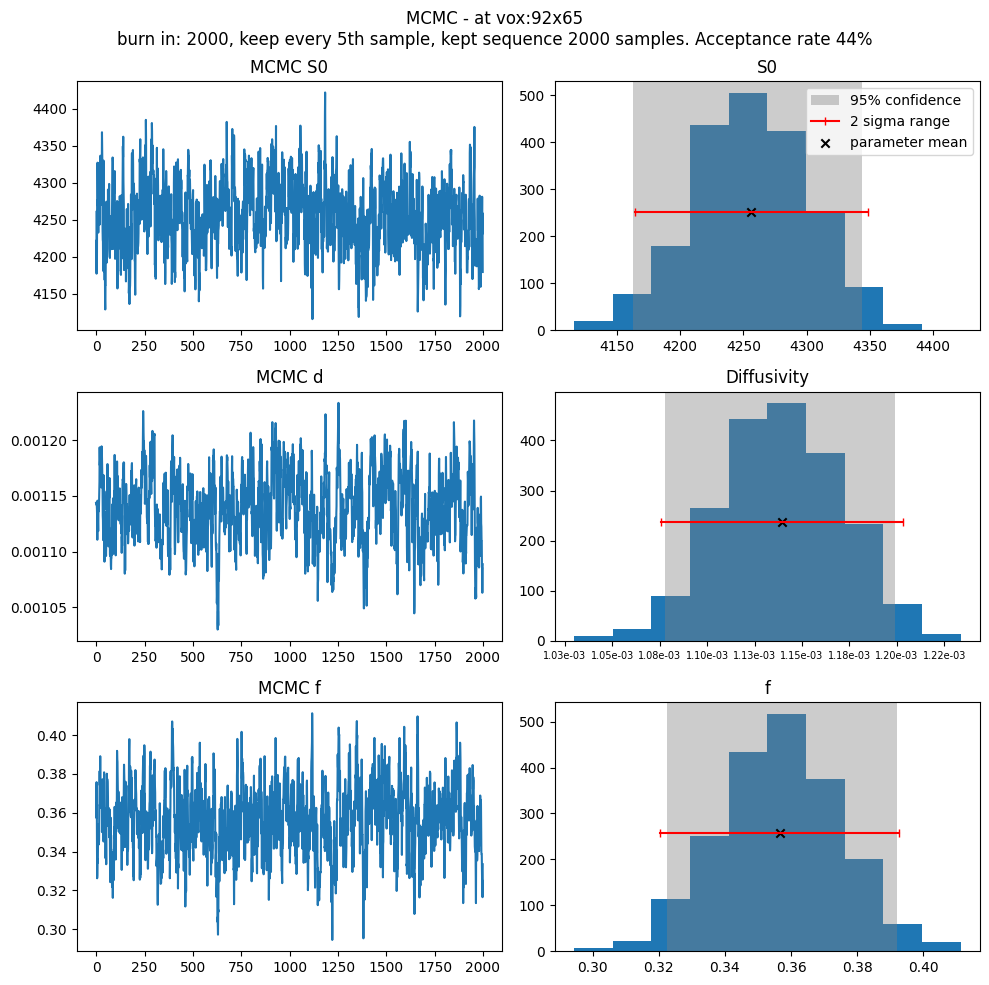

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle(f'MCMC - at vox:{vox_i+1}x{vox_j+1}\nburn in: {burn_in}, keep every {stride}th sample, kept sequence {sample_length} samples. Acceptance rate {100*acceptance_rate:.0f}%')

MCMC_S0 = MCMC_sequence[:,0]
MCMC_d = MCMC_sequence[:,1]
MCMC_f = MCMC_sequence[:,2]

burn_in_colour = 'grey'
shade_alpha = 0.4

axs[0,0].plot(MCMC_S0)
axs[0,0].set_title('MCMC S0')
axs[1,0].plot(MCMC_d)
axs[1,0].set_title('MCMC d')
axs[2,0].plot(MCMC_f)
axs[2,0].set_title('MCMC f')

MCMC_95_range, MCMC_2sigma_range = plot_histogram_sigma_95percent(axs[0, 1], MCMC_S0, 'S0', is_legend=True)
MCMC_95_range, MCMC_2sigma_range = plot_histogram_sigma_95percent(axs[1, 1], MCMC_d, 'Diffusivity')
MCMC_95_range, MCMC_2sigma_range = plot_histogram_sigma_95percent(axs[2, 1], MCMC_f, 'f')

axs[1,1].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
axs[1,1].tick_params(axis='x', labelsize=7)

print('MCMC parameter ranges\n')
print(f'Voxel: {vox_i+1}x{vox_j+1}')
print(f"S0: mean = {MCMC_S0.mean()}, 95% confidence = {MCMC_95_range}, 2sigma range = {MCMC_2sigma_range}")
print(f"Diffusivity: mean = {MCMC_d.mean()}, 95% confidence = {MCMC_95_range}, 2sigma range = {MCMC_2sigma_range}")
print(f"f: mean = {MCMC_f.mean()}, 95% confidence = {MCMC_95_range}, 2sigma range = {MCMC_2sigma_range}\n")

plt.tight_layout()

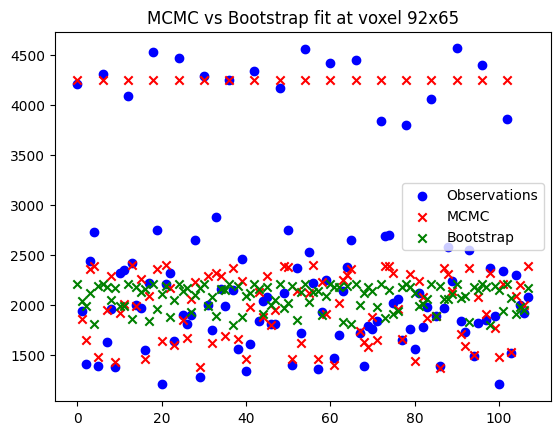

In [127]:
# Compare the Boostrap output to MCMC output
MCMC_x = np.array([MCMC_S0.mean(),
                   MCMC_d.mean(),
                   MCMC_f.mean(),
                   MCMC_sequence[:,3].mean(),
                   MCMC_sequence[:,4].mean()])
bootstrap_x = np.array([bootstrap_parameters.mean(axis=0)[0],
                        bootstrap_parameters.mean(axis=0)[1],
                        bootstrap_parameters.mean(axis=0)[2],
                        bootstrap_parameters.mean(axis=0)[3],
                        bootstrap_parameters.mean(axis=0)[4]])

MCMC_est = ball_stick(MCMC_x)
bootstrap_est = ball_stick(bootstrap_x)
A_exact = np.squeeze(dwis[:,vox_i,vox_j,im_slice])

MCMC_SSD = BallStickSSD(MCMC_x, dwis[:,vox_i,vox_j,im_slice])
bootstrap_SSD = BallStickSSD(bootstrap_x, dwis[:,vox_i,vox_j,im_slice])

# Create grid of subplots to compare
plt.scatter(np.arange(108), A_exact, marker='o', color='b', label='Observations')
plt.scatter(np.arange(108), MCMC_est, marker='x', color='r', label='MCMC')
plt.scatter(np.arange(108), bootstrap_est, marker='x', color='g', label='Bootstrap')
plt.legend()
plt.title(f'MCMC vs Bootstrap fit at voxel {vox_i+1}x{vox_j+1}')
plt.show()



# Q1.3.1

In [28]:
# load in normalised data
# D.shape = 3612x6
# D has headers: vox1, vox2, vox3, vox4, vox5, vox6
D = np.genfromtxt('isbi2015_data_normalised.txt', skip_header=1, dtype=float, encoding='utf-8')

# load in protocol
# A.shape = 3612x7
# A has headers: dir-x, dir-y, dir-z, |G|, DELTA, delta, TE
A = np.genfromtxt('isbi2015_protocol.txt', skip_header=1, dtype=float, encoding='utf-8')

# dir-x, dir-y, dir-z
grad_dirs = A[:,0:3]    # mT/mm
G = A[:,3]              # mT/mm
delta = A[:,4]          # s x10-6
smalldel = A[:,5]       # ms (10x-3)
TE = A[:,6]             # s x10-6

GAMMA = 2.675987e8

bvals = ((GAMMA * smalldel * G)**2) * (delta - (smalldel / 3))
# convert bvals to s/mm^2 from s/m^2
bvals = bvals / (10**6)
qhat = grad_dirs

num_vox = D.shape[1]
noise_std = 0.04

In [29]:
def model_SSD_constrained_findSSDmin(model_constrained_SSD, transform, transform_inv, max_iter, startx, avox):
    # given parameters of a single avox, run max_iter times and find converged SSD each time
    # return best found solution and SSD value
    
    noise_std = np.abs(startx / 5)
    num_parameters = startx.size
    X_single_voxel = np.zeros((max_iter, num_parameters))
    X_SSD = np.zeros(max_iter)

    for i in range(max_iter):
        # find some noise, add to the start, and transform and inverse it to make sure the 
        # peturbed start is a realistic start
        noise = np.random.normal(loc=np.zeros(num_parameters), scale=noise_std)
        x_i = startx + noise
        x_i = transform_inv(transform(x_i))
        results = minimize(
            fun=model_constrained_SSD,
            x0=transform_inv(x_i),
            args=(avox,),
        )
        X_single_voxel[i,:] = results['x']
        SSD_result = results['fun']
        if np.isnan(SSD_result):
            SSD_result = np.inf
        X_SSD[i] = SSD_result
    
    min_idx = np.argmin(X_SSD)
    x = X_single_voxel[min_idx]
    min_SSD = X_SSD[min_idx]
    min_SSD_count = np.isclose(X_SSD, min_SSD, 1e-1).sum()
    
    return x, min_SSD, min_SSD_count

In [30]:
def model_plot_results(model, X, voxels, RESNORMs, model_name):

    # plot the results
    col_num = 2
    row_num = 3
    data_num = voxels.shape[0]

    fig, axs = plt.subplots(col_num, row_num, figsize=(10, 10))
    fig.suptitle(model_name)

    vox = 0
    for col in range(2):
        for row in range(3):
            A_est = model(X[vox])
            A_exact = np.squeeze(voxels[:,vox])

            # Create grid of subplots to compare
            axs[col, row].scatter(np.arange(data_num), A_exact, marker='o', color='b', label='Observations')
            axs[col,row].scatter(np.arange(data_num), A_est, marker='x', color='r', label='Model Estimate')
            axs[col, row].set_title(f'Voxel {vox + 1}\nRESNORM: {RESNORMs[vox]:.1f}')
            axs[col,row].legend()
            
            vox = vox+1
    
    plt.show()

Find solution for Ball & Stick model and plot for each voxel

In [31]:
# solve for x in each voxel
num_param = 5
max_iter = 20
BS_startx = np.array([1, 5.0e-03, 8e-01, 1.0e+00, 1.0e+00])

BS_results = np.zeros(shape=(num_vox, num_param))
BS_SSD_results = np.zeros(shape=(num_vox))

for vox in range(num_vox):
    x, min_SSD, min_SSD_count = model_SSD_constrained_findSSDmin(BallStickSSD_constrained, transform, transform_inv, max_iter, BS_startx, D[:,vox])
    BS_results[vox] = transform(x)
    BS_SSD_results[vox] = min_SSD
    print(find_N_for_95percent_global_min(min_SSD_count / max_iter))

2
59
29
14
19
59


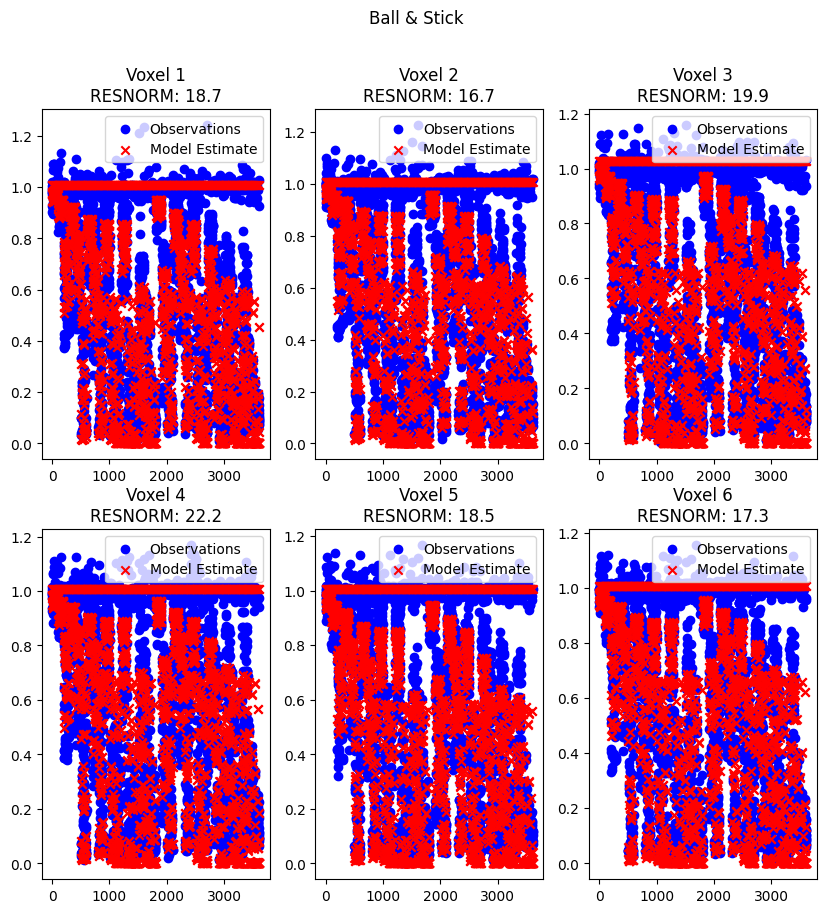

In [32]:
model_plot_results(ball_stick, BS_results, D, BS_SSD_results, 'Ball & Stick')

# Q1.3.2

In [33]:
# Define the different models
# NOTE: qhat and bvals have to be globally set before calling any of these models

# Diffusion Tensor
def DT_model(x):
    S0, Dxx, Dxy, Dxz, Dyy, Dyz, Dzz = x
    
    Diff = np.array(
            [[Dxx, Dxy, Dxz],
             [Dxy, Dyy, Dyz],
             [Dxz, Dyz, Dzz]])
         
    S = S0 * np.exp(-bvals * (qhat @ Diff @ qhat.T).diagonal())
    return S


def zeppelin_stick_model(x):
    # eig_val_1 >= eig_val_2 > 0
    # eig_val_1 is assumed to be the same size as diffusivity
    # eig_val_1 is in the same direction as the fibre direction (n_hat)
    # eig_val_1 = eig_val_2 + eig_val_diff
    # eigenvalues are setup this way so we can easily constrain the inputs
    S0, eig_val_2, eig_val_diff, f, theta, phi = x
    
    eig_val_1 = eig_val_2 + eig_val_diff
    
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta),
    ])
    
    # creates a 2D array of fibdir stacked ontop of each other len(bvals) times
    # so now has the dimensions [len(bvals)x3]
    tile = np.tile(fibdir, (len(bvals), 1))
    fibdotgrad = np.sum(qhat * tile, axis=1)
    
    # intra-cellular signal
    # note: largest eigen value is assumed to be the same as the diffusivity
    # so we can substitue it in here
    S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
    
    # extra-cellular signal
    S_e = np.exp(-bvals * (eig_val_2 + (eig_val_1 - eig_val_2) * (fibdotgrad**2)))
    
    # total signal S
    S = S0 * (f * S_i + (1-f) * S_e)
    
    return S


def zeppelin_stick_tur_model(x):
    # same as Zeppelin_stick_model but with eig_val_2 = (1-f)*eig_val_1
    S0, eig_val_2, f, theta, phi = x
    eig_val_1 = eig_val_2 / (1-f)
    
    y = [S0, eig_val_1, eig_val_2, f, theta, phi]
    
    return zeppelin_stick_model(y)


def model_SSD(model, x, voxel):
    # given a model calculate the modelled signals and return the sum of square difference
    # compared to the observed signals
    S = model(x)
    return np.sum((voxel - S) ** 2)

In [34]:
# We are now constraining the parameters (S0, diff >0, f in (0,1), theta, phi in (0,2pi))
# We do this by transforming x to be squared, or expit() and scaled to ensure they are in the 
# correct domain. Because the transformation happens after the optimizer guesses x_t+1 we
# have to transform the optimized solution to get the correct fitted parameters


def DT_transform_inv(x):
    # Given x we transform it to what we want to optimize to constrain it
    # x = S0, Dxx, Dxy, Dxz, Dyy, Dyz, Dzz
    Dxx = x[1]
    Dxy = x[2]
    Dxz = x[3]
    Dyy = x[4]
    Dyz = x[5]
    Dzz = x[6]
    
    # Use the cholesky decomposition to constrain D = L @ L.T
    D = np.array(
            [[Dxx, Dxy, Dxz],
             [Dxy, Dyy, Dyz],
             [Dxz, Dyz, Dzz]])
    
    L = np.linalg.cholesky(D)
    Lxx = L[0,0]
    Lxy = L[0,1]
    Lxz = L[0,2]
    Lyy = L[1,1]
    Lyz = L[1,2]
    Lzz = L[2,2]
    
    return [x[0]**0.5, Lxx, Lxy, Lxz, Lyy, Lyz, Lzz]


def DT_transform(x):
    # Given transformed x return parameters we are looking for
    # x = abs(SO)**0.5, Lxx, Lxy, Lxz, Lyy, Lyz, Lzz
    # where L is the cholesky decomposition D = L @ L.T
    Lxx = x[1]
    Lxy = x[2]
    Lxz = x[3]
    Lyy = x[4]
    Lyz = x[5]
    Lzz = x[6]
    
    L = np.array(
            [[Lxx, 0, 0],
             [Lxy, Lyy, 0],
             [Lxz, Lyz, Lzz]])
    
    D = L @ L.T
    Dxx = D[0,0]
    Dxy = D[0,1]
    Dxz = D[0,2]
    Dyy = D[1,1]
    Dyz = D[1,2]
    Dzz = D[2,2]

    return [x[0]**2, Dxx, Dxy, Dxz, Dyy, Dyz, Dzz]


def DT_constrained_SSD(x, voxel):
    S = DT_model(DT_transform(x))
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)


In [35]:
# Transformation functions for Zeppelin Stick model

def zeppelin_stick_transform_inv(x):
    # Given x we transform it to what we want to optimize to constrain it
    # x = S0, eig_val_2, eig_val_diff, f, theta, phi
    return [x[0]**0.5, x[1]**0.5, x[2]**0.5, logit(x[3]), logit(x[4]/np.pi), logit(x[5]/(2*np.pi))]


def zeppelin_stick_transform(x):
    # Given transformed x return parameters we are looking for
    # x = abs(SO)**0.5, abs(eig_val_2)**0.5, abs(eig_val_diff)**0.5, expit(f), expit(theta), expit(phi)
    return [x[0]**2, x[1]**2, x[2]**2, expit(x[3]), expit(x[4])*np.pi, expit(x[5])*2*np.pi]


def zeppelin_stick_constrained_SSD(x, voxel):
    S = zeppelin_stick_model(zeppelin_stick_transform(x))
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)


In [36]:
# Transformation functions for Zeppelin Stick Turtuosity model

def zeppelin_stick_tur_transform_inv(x):
    # Given x we transform it to what we want to optimize to constrain it
    # x = S0, eig_val_2, f, theta, phi
    return [x[0]**0.5, x[1]**0.5, logit(x[2]), logit(x[3]/np.pi), logit(x[4]/(2*np.pi))]


def zeppelin_stick_tur_transform(x):
    # Given transformed x return parameters we are looking for
    # x = abs(SO)**0.5, abs(eig_val_2)**0.5, expit(f), expit(theta), expit(phi)
    return [x[0]**2, x[1]**2, expit(x[2]), expit(x[3])*np.pi, expit(x[4])*2*np.pi]


def zeppelin_stick_tur_constrained_SSD(x, voxel):
    S = zeppelin_stick_tur_model(zeppelin_stick_tur_transform(x))
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)


In [37]:
# Use least squares to get an estimate on D before using the minimise function

data_range = [0,1000]
data_num = data_range[1] - data_range[0]

# Solve for x in log(A) = Gx - where x has all unknowns
x = np.zeros(7)
quadratic_matrix = -bvals[data_range[0]:data_range[1]] * np.array([qhat[data_range[0]:data_range[1],0]**2, 2*qhat[data_range[0]:data_range[1],0]*qhat[data_range[0]:data_range[1],1], 2*qhat[data_range[0]:data_range[1],0]*qhat[data_range[0]:data_range[1],2], qhat[data_range[0]:data_range[1],1]**2, 2*qhat[data_range[0]:data_range[1],1]*qhat[data_range[0]:data_range[1],2], qhat[data_range[0]:data_range[1],2]**2])
G = np.concatenate([np.ones((data_range[1] - data_range[0],1)), quadratic_matrix.T], axis=1)


A = D[data_range[0]:data_range[1],0]
W = np.diag(A**2)
invmap = np.linalg.pinv(G.T @ W @ G) @ G.T @ W
x = invmap @ np.log(A)

Dxx = x[1]
Dxy = x[2]
Dxz = x[3]
Dyy = x[4]
Dyz = x[5]
Dzz = x[6]
DT = np.array(
    [[Dxx, Dxy, Dxz],
        [Dxy, Dyy, Dyz],
        [Dxz, Dyz, Dzz]]
)

y = x.copy()
y[0] = np.exp(y[0])
print(f'solution found from MSE: {y}')

solution found from MSE: [ 9.79412984e-01  1.63993632e-03 -9.62828497e-05 -7.21340454e-05
  2.21759667e-04  3.36809061e-05  2.38570195e-04]


In [38]:
# Use the transform to find the parameters constrained
DT_startx = y

# solve for x in each voxel
num_param = DT_startx.size
max_iter = 10

DT_results = np.zeros(shape=(num_vox, num_param))
DT_SSD_results = np.zeros(shape=(num_vox))

for vox in range(num_vox):
    x, min_SSD, min_SSD_count = model_SSD_constrained_findSSDmin(DT_constrained_SSD, DT_transform, DT_transform_inv, max_iter, DT_startx, D[:,vox])
    DT_results[vox] = DT_transform(x)
    DT_SSD_results[vox] = min_SSD
    print(find_N_for_95percent_global_min(min_SSD_count / max_iter))

C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1567583007.py:44: RuntimeWarning: divide by zero encountered in log
  return int(np.ceil(np.log(0.05) / np.log(1-p)))


0


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1567583007.py:44: RuntimeWarning: divide by zero encountered in log
  return int(np.ceil(np.log(0.05) / np.log(1-p)))


0


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1567583007.py:44: RuntimeWarning: divide by zero encountered in log
  return int(np.ceil(np.log(0.05) / np.log(1-p)))


0


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1567583007.py:44: RuntimeWarning: divide by zero encountered in log
  return int(np.ceil(np.log(0.05) / np.log(1-p)))


0


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1567583007.py:44: RuntimeWarning: divide by zero encountered in log
  return int(np.ceil(np.log(0.05) / np.log(1-p)))


0
0


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1567583007.py:44: RuntimeWarning: divide by zero encountered in log
  return int(np.ceil(np.log(0.05) / np.log(1-p)))


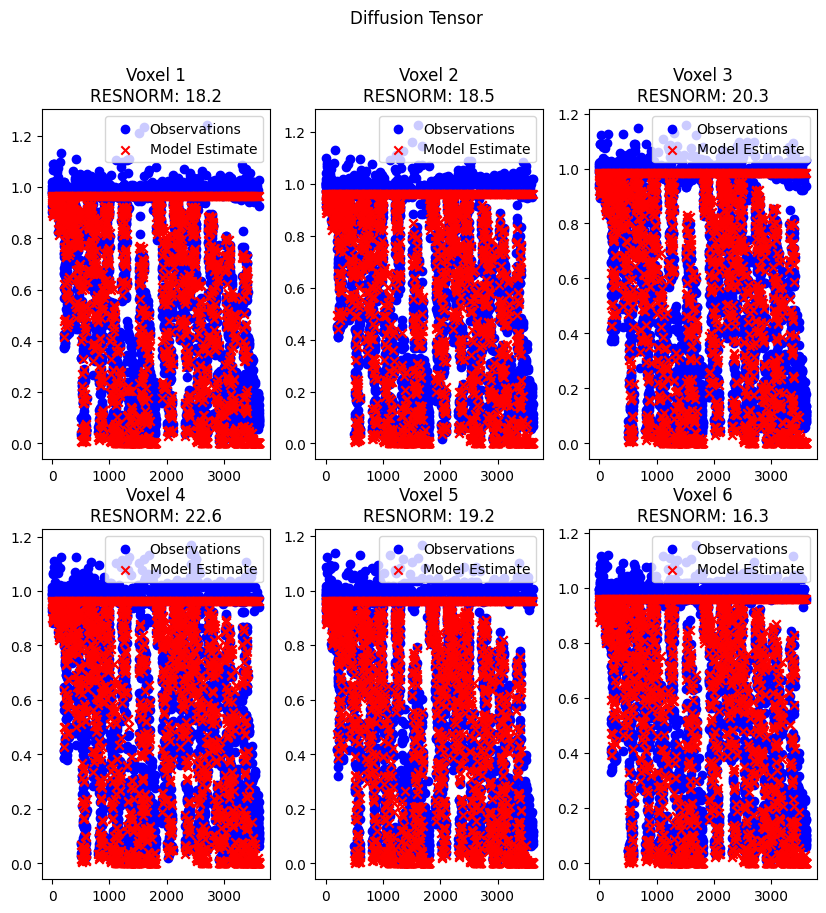

In [39]:
model_plot_results(DT_model, DT_results, D, DT_SSD_results, 'Diffusion Tensor')

In [40]:
# Use the transform to find the parameters constrained
zep_stick_startx = np.array([1,1e-3,1-3,0.5,1,1])

# solve for x in each voxel
num_param = zep_stick_startx.size
max_iter = 60

zep_stick_results = np.zeros(shape=(num_vox, num_param))
zep_stick_SSD_results = np.zeros(shape=(num_vox))

for vox in range(num_vox):
    x, min_SSD, min_SSD_count = model_SSD_constrained_findSSDmin(zeppelin_stick_constrained_SSD, zeppelin_stick_transform, zeppelin_stick_transform_inv, max_iter, zep_stick_startx, D[:,vox])
    zep_stick_results[vox] = zeppelin_stick_transform(x)
    zep_stick_SSD_results[vox] = min_SSD
    print(find_N_for_95percent_global_min(min_SSD_count / max_iter))

44
44
35
35
35
44


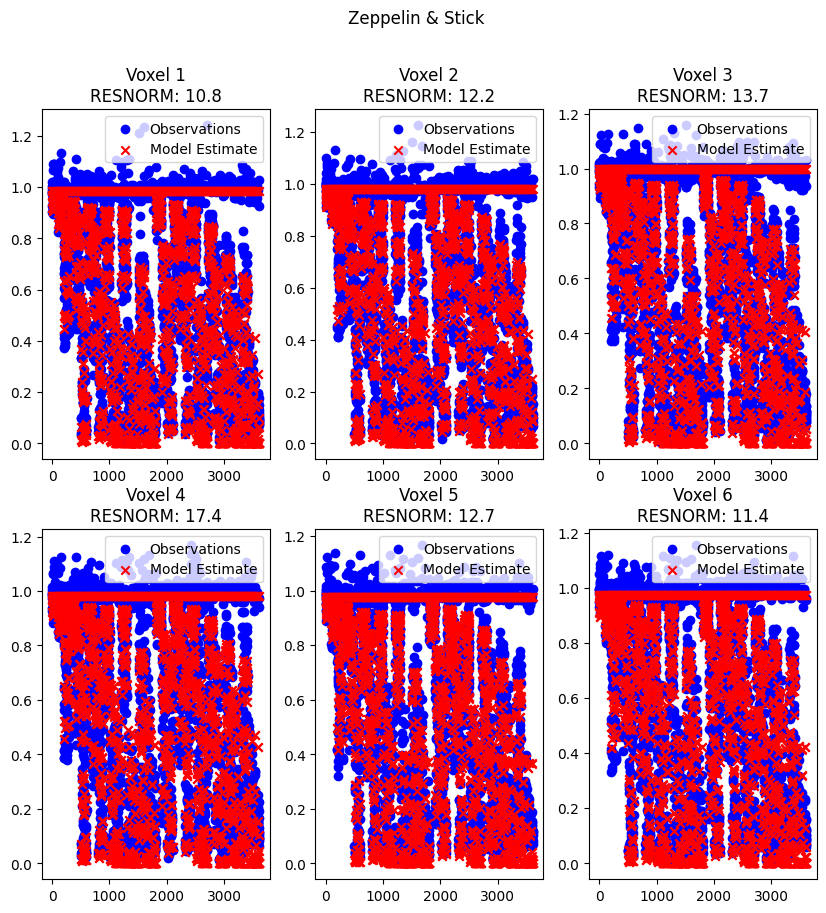

In [41]:
model_plot_results(zeppelin_stick_model, zep_stick_results, D, zep_stick_SSD_results, 'Zeppelin & Stick')

In [48]:
zep_stick_results

array([[9.83028602e-01, 4.67595491e-04, 1.11588880e-03, 4.35376717e-01,
        1.54384331e+00, 3.04885099e+00],
       [9.82771729e-01, 3.88046638e-04, 1.08961176e-03, 4.57090823e-01,
        1.53216398e+00, 3.05667230e+00],
       [9.99976808e-01, 3.66804441e-04, 1.21234525e-03, 4.25772078e-01,
        1.58119964e+00, 3.00501663e+00],
       [9.81735867e-01, 3.17196471e-04, 1.21241031e-03, 4.79144995e-01,
        1.58182833e+00, 3.02983618e+00],
       [9.78653064e-01, 3.99085180e-04, 1.33864673e-03, 4.04436391e-01,
        1.63514727e+00, 2.98538910e+00],
       [9.74694743e-01, 2.90024945e-04, 1.41970202e-03, 4.34921198e-01,
        1.60743199e+00, 3.00650271e+00]])

In [50]:
# Use the transform to find the parameters constrained
zep_stick_tur_startx = np.array([1,5e-4,0.5,0.1,1])

# solve for x in each voxel
num_param = zep_stick_tur_startx.size
max_iter = 200

zep_stick_tur_results = np.zeros(shape=(num_vox, num_param))
zep_stick_tur_SSD_results = np.zeros(shape=(num_vox))

for vox in range(num_vox):
    x, min_SSD, min_SSD_count = model_SSD_constrained_findSSDmin(zeppelin_stick_tur_constrained_SSD, zeppelin_stick_tur_transform, zeppelin_stick_tur_transform_inv, max_iter, zep_stick_tur_startx, D[:,vox])
    zep_stick_tur_results[vox] = zeppelin_stick_tur_transform(x)
    zep_stick_tur_SSD_results[vox] = min_SSD
    print(find_N_for_95percent_global_min(min_SSD_count / max_iter))

C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  eig_val_1 = eig_val_2 / (1-f)
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:41: RuntimeWarning: invalid value encountered in multiply
  S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:44: RuntimeWarning: invalid value encountered in double_scalars
  S_e = np.exp(-bvals * (eig_val_2 + (eig_val_1 - eig_val_2) * (fibdotgrad**2)))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  eig_val_1 = eig_val_2 / (1-f)
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:41: RuntimeWarning: invalid value encountered in multiply
  S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:44: RuntimeWarning: invalid value encountered in double_scala

8


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  eig_val_1 = eig_val_2 / (1-f)
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:41: RuntimeWarning: invalid value encountered in multiply
  S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:44: RuntimeWarning: invalid value encountered in double_scalars
  S_e = np.exp(-bvals * (eig_val_2 + (eig_val_1 - eig_val_2) * (fibdotgrad**2)))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  eig_val_1 = eig_val_2 / (1-f)
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:41: RuntimeWarning: invalid value encountered in multiply
  S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:44: RuntimeWarning: invalid value encountered in double_scala

598


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  eig_val_1 = eig_val_2 / (1-f)
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:41: RuntimeWarning: invalid value encountered in multiply
  S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:44: RuntimeWarning: invalid value encountered in double_scalars
  S_e = np.exp(-bvals * (eig_val_2 + (eig_val_1 - eig_val_2) * (fibdotgrad**2)))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  eig_val_1 = eig_val_2 / (1-f)
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:41: RuntimeWarning: invalid value encountered in multiply
  S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:44: RuntimeWarning: invalid value encountered in double_scala

4


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  eig_val_1 = eig_val_2 / (1-f)
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:41: RuntimeWarning: invalid value encountered in multiply
  S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:44: RuntimeWarning: invalid value encountered in double_scalars
  S_e = np.exp(-bvals * (eig_val_2 + (eig_val_1 - eig_val_2) * (fibdotgrad**2)))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  eig_val_1 = eig_val_2 / (1-f)
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:41: RuntimeWarning: invalid value encountered in multiply
  S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:44: RuntimeWarning: invalid value encountered in double_scala

598


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  eig_val_1 = eig_val_2 / (1-f)
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:41: RuntimeWarning: invalid value encountered in multiply
  S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:44: RuntimeWarning: invalid value encountered in double_scalars
  S_e = np.exp(-bvals * (eig_val_2 + (eig_val_1 - eig_val_2) * (fibdotgrad**2)))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  eig_val_1 = eig_val_2 / (1-f)
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:41: RuntimeWarning: invalid value encountered in multiply
  S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:44: RuntimeWarning: invalid value encountered in double_scala

4


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  eig_val_1 = eig_val_2 / (1-f)
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:41: RuntimeWarning: invalid value encountered in multiply
  S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:44: RuntimeWarning: invalid value encountered in double_scalars
  S_e = np.exp(-bvals * (eig_val_2 + (eig_val_1 - eig_val_2) * (fibdotgrad**2)))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  eig_val_1 = eig_val_2 / (1-f)
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:41: RuntimeWarning: invalid value encountered in multiply
  S_i = np.exp(-bvals * eig_val_1 * (fibdotgrad**2))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8716\1393363920.py:44: RuntimeWarning: invalid value encountered in double_scala

4


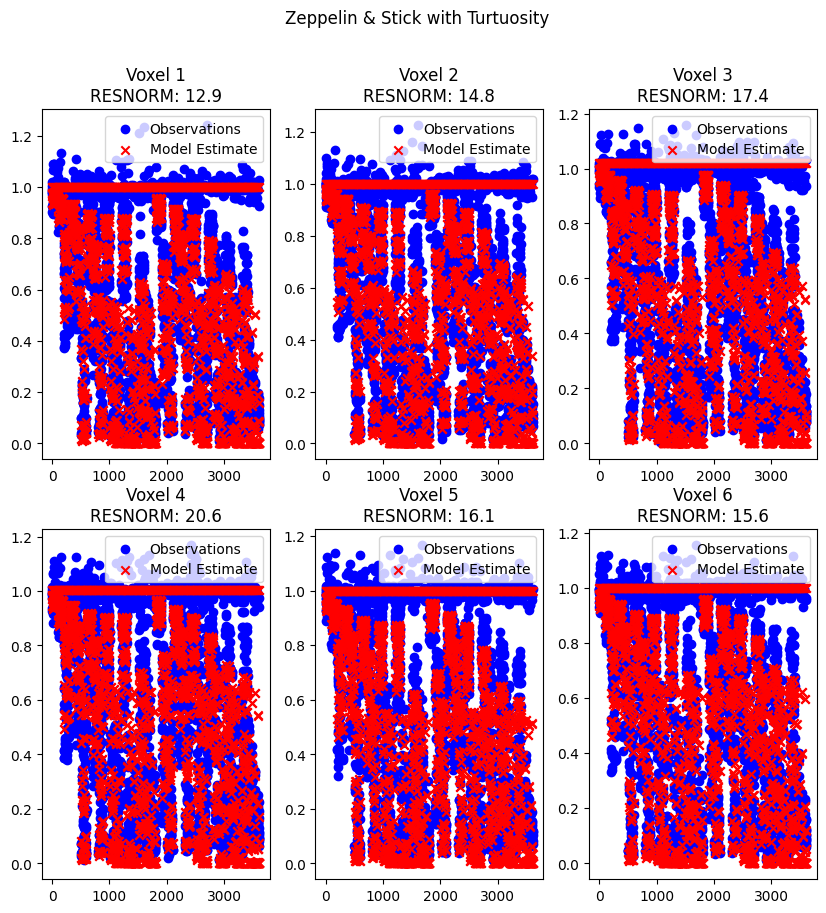

In [43]:
model_plot_results(zeppelin_stick_tur_model, zep_stick_tur_results, D, zep_stick_tur_SSD_results, 'Zeppelin & Stick with Turtuosity')

# Q1.3.3


In [44]:
def log_like(A_est, A_exact, noise_std):
    var = noise_std**2
    diff_squared_sum = ((A_est - A_exact)**2).sum()
    log_like = ( -0.5 * np.log(2*np.pi*var) - (1/(2*var)) * diff_squared_sum )
    return log_like


def AIC(A_est, A_exact, deg_freedom, noise_std):
    # we are calculating the noise directly so we don't have to increase N by 1
    N = deg_freedom
    K = A_est.shape[0]
    
    if K/N < 40:
        print('WARNING: K/N > 40 -> should use adjusted AIC')
    
    LogL = log_like(A_est, A_exact, noise_std)
    AIC = 2*N - 2*LogL
    return AIC


def BIC(A_est, A_exact, deg_freedom, noise_std):
    # we are calculating the noise directly so we don't have to increase N by 1
    N = deg_freedom
    K = A_est.shape[0]
    
    LogL = log_like(A_est, A_exact, noise_std)
    BIC = N*np.log(K) - 2*LogL
    return BIC

In [45]:
# calculate the AIC and BIC for each model
data_num = D.shape[0]
num_vox = D.shape[1]

BS_preds = np.zeros(shape=(D.size))
DT_preds = np.zeros_like(BS_preds)
zeppelin_stick_preds = np.zeros_like(BS_preds)
zeppelin_stick_tur_preds = np.zeros_like(BS_preds)

for vox in range(num_vox):
    start_idx = vox*data_num
    end_idx = start_idx + data_num
    
    BS_preds[start_idx:end_idx] = ball_stick(BS_results[vox])
    DT_preds[start_idx:end_idx] = DT_model(DT_results[vox])
    zeppelin_stick_preds[start_idx:end_idx] = zeppelin_stick_model(zep_stick_results[vox])
    zeppelin_stick_tur_preds[start_idx:end_idx] = zeppelin_stick_tur_model(zep_stick_tur_results[vox])

data = D.flatten(order='F')

AICs = np.array([AIC(BS_preds, data, deg_freedom=5, noise_std=0.04),
                 AIC(DT_preds, data, deg_freedom=7, noise_std=0.04),
                 AIC(zeppelin_stick_preds, data, deg_freedom=6, noise_std=0.04),
                 AIC(zeppelin_stick_tur_preds, data, deg_freedom=5, noise_std=0.04),])

BICs = np.array([BIC(BS_preds, data, deg_freedom=5, noise_std=0.04),
                 BIC(DT_preds, data, deg_freedom=7, noise_std=0.04),
                 BIC(zeppelin_stick_preds, data, deg_freedom=6, noise_std=0.04),
                 BIC(zeppelin_stick_tur_preds, data, deg_freedom=5, noise_std=0.04),])

In [46]:
models = {0:'BS', 1:'DT', 2:'zep_stick', 3:'zep_stick_tur'}
AIC_rank = np.argsort(AICs)
BIC_rank = np.argsort(BICs)

AIC_text = 'AIC: model ranking best to worst\n'
BIC_text = 'BIC: model ranking best to worst\n'
for rank in range(4):
    str = f'Rank {rank}: model {models[AIC_rank[rank]]} with AIC {AICs[AIC_rank[rank]]:.1f}\n'
    AIC_text = AIC_text + str
    str = f'Rank {rank}: model {models[BIC_rank[rank]]} with BIC {BICs[BIC_rank[rank]]:.1f}\n'
    BIC_text = BIC_text + str
print(AIC_text)
print(BIC_text)



AIC: model ranking best to worst
Rank 0: model zep_stick with AIC 48826.6
Rank 1: model zep_stick_tur with AIC 60863.9
Rank 2: model BS with AIC 70832.8
Rank 3: model DT with AIC 72009.9

BIC: model ranking best to worst
Rank 0: model zep_stick with BIC 48874.5
Rank 1: model zep_stick_tur with BIC 60903.8
Rank 2: model BS with BIC 70872.7
Rank 3: model DT with BIC 72065.8



# q1.3.4

In [47]:
def B2S_model(x):
    # Behrens et al, 2003
    # Characterization and Propagation of Uncertainty in Diffusion-Weighted MR Imaging
    # https://doi.org/10.1002/mrm.10609
    
    # Extract the parameters
    # diff: diffusion
    # f: fraction of signal contributed by diffusion tensor along fiber direction theta, phi
    S0, diff, f2, f_diff, theta1, phi1, theta2, phi2 = x
    f1 = f2 + f_diff
    
    # Fiber direction
    fibdir1 = np.array([
        np.cos(phi1) * np.sin(theta1),
        np.sin(phi1) * np.sin(theta1),
        np.cos(theta1),
    ])
    fibdir2 = np.array([
        np.cos(phi2) * np.sin(theta2),
        np.sin(phi2) * np.sin(theta2),
        np.cos(theta2),
    ])
    
    # creates a 2D array of fibdir stacked ontop of each other len(bvals) times
    # so now has the dimensions [len(bvals)x3]
    tile = np.tile(fibdir1, (len(bvals), 1))
    fibdotgrad1 = np.sum(qhat * tile, axis=1)
    tile = np.tile(fibdir2, (len(bvals), 1))
    fibdotgrad2 = np.sum(qhat * tile, axis=1)
    
    # calculate intra and extra contributions to the model
    Si1 = np.exp(-bvals * diff * (fibdotgrad1**1))
    Si2 = np.exp(-bvals * diff * (fibdotgrad2**2))
    Se = np.exp(-bvals * diff)
    
    S = S0 * (f1 * Si1 + f2 * Si2 + (1-f1-f2) * Se)
    return S


def B2S_SSD(x, voxel):
    S = B2S_model(x)
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)


# Given S0, diff, f2, f_diff, theta1, phi1, theta2, phi2 - we transform to constrain it
# f1 = f2 + f_diff
# 1 > f1 >= f2 >=0
def B2S_transform(x):
    
    return [x[0]**0.5, x[1]**0.5,
            logit(x[2]), logit(x[3]),
            logit(x[4]/np.pi), logit(x[5]/(2*np.pi)),
            logit(x[6]/np.pi), logit(x[7]/(2*np.pi))]

# Given transformed x return parameters we are looking for
def B2S_transform_inv(x):
    
    return [x[0]**2, x[1]**2,
            expit(x[2]), expit(x[3]),
            expit(x[4])*np.pi, expit(x[5])*2*np.pi,
            expit(x[6])*np.pi, expit(x[7])*2*np.pi]

def B2S_constrained(x, voxel):
    S = B2S_model(transform(x))
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)

# calculating the transform for the 2 stick model